In [1]:
import torch

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [3]:
import torch
import torch.nn as nn

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emp = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx:torch.Tensor): # in_idx 输入序列
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emp(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print('Output shape:', logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [19]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:", mean)
print("Var:", var)

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Var: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [20]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized Output:", out_norm)
print("Mean:\n", mean)
print("Var:\n", var)

Normalized Output: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Var:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [22]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # 使用有偏估计，即(1/n) * Σ(x-x_mean)^2，如果是无偏估计则为(1/(n-1))
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [25]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean:\n", mean)
print("Var:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Var:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [27]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

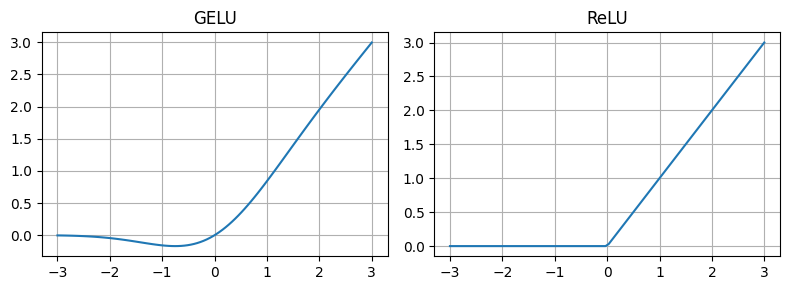

In [28]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu = gelu(x)
y_relu = relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x.numpy(), y.numpy())
    plt.title(label)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_dim'] * 4),
            GELU(),
            nn.Linear(cfg['emb_dim'] * 4, cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [30]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [31]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [32]:
layer_sizes = [3, 3, 3, 3, 3, 1]
simple_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [33]:
def print_gradients(model:nn.Module, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss_value = loss(output, target)
    loss_value.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')

In [34]:
print_gradients(model_without_shortcut, simple_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [35]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, True)
print_gradients(model_with_shortcut, simple_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.context_length = context_length
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x:torch.Tensor):
        batch_size, seq_len, dim = x.shape
        queries = self.W_q(x) # shape (B,L,D)
        keys = self.W_k(x)
        values = self.W_V(x)
        # 分头
        queries = queries.view(batch_size, seq_len, self.num_heads, self.head_dim) # shape (B,L,H,H_D)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # 交换位置，适配多头计算
        queries = queries.transpose(1, 2) # shape (B,H,L,H_D)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        # 计算注意力分数
        attn_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5 # shape (B,H,L,L)
        attn_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights) # shape (B,H,L,L)
        # 计算加权值
        context_vec = attn_weights @ values # shape (B,H,L,H_D)
        context_vec = context_vec.transpose(1,2) # shape (B,L,H,H_D)
        context_vec = context_vec.contiguous().view(batch_size, seq_len, dim)
        return self.out_proj(context_vec)

In [39]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(d_in=cfg['emb_dim'],
                                      d_out=cfg['emb_dim'],
                                      context_length=cfg['context_length'],
                                      num_heads=cfg['n_heads'],
                                      dropout=cfg['drop_rate'],
                                      qkv_bias=cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shrotcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x += shrotcut

        shrotcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x += shrotcut
        return x

In [46]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print('Input shape:', x.shape)
print('Output shape:', output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [70]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emp = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx:torch.Tensor):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emp(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [71]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print('Input shape:', batch.shape)
print('Output shape:', out.shape)
print(out)

Input shape: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [72]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in model: {total_params}')

Total parameters in model: 163009536


In [51]:
model.tok_emb.weight.shape

torch.Size([50257, 768])

In [52]:
model.out_head.weight.shape

torch.Size([50257, 768])

In [63]:
model.pos_emb.weight.shape

torch.Size([1024, 768])

In [60]:
total_params - model.out_head.parameters().__next__().numel()

124412160

In [61]:
model.trf_blocks.parameters().__next__().numel()

589824

In [73]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # 取从当前序列的最后context_size个token作为条件输入
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # 取最后一个时间步的logits
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [74]:
model.pos_emb(torch.arange(10)).shape

torch.Size([10, 768])

In [75]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 添加batch维度
print("encoded_tensor shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor shape: torch.Size([1, 4])


In [76]:
model.eval()
out = generate_text_simple(model=model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M['context_length'])
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [79]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded text:", decoded_text)

Decoded text: Hello, I am Featureiman Byeswickattribute argue
